# Discovery Memo
## Tereza Petrovicova 

For this memo, I expanded my data collection from the representation memo by scraping additional 10-K filings. Specifically, I included 10-K reports for companies in the Mining, Quarrying, and Oil and Gas Extraction sector (NAICS 21). As a result, this memo covers a total of 149 companies from two NAICS sectors: 93 companies in sector 21 (Mining, Quarrying, and Oil and Gas Extraction) and 56 companies in sector 22 (Utilities). I also focused exclusively on 10-K filings from 2024 to ensure the code ran efficiently. While I scraped the data fror each company for the last 10 years, processing all of it at once was really time-consuming. For example, when I tried doing this memo using my whole dataset, the pre-processing took 30 minutes and the other steps about 10 minutes each.  However, for the final project, I plan to extend the analysis to include 10-K filings from the past 10 or even 20 years. 

In [ ]:
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn  # sklearn is part of scikit-learn
# !pip install gensim
# !pip install matplotlib

In [52]:
import pandas as pd
import os

# Set the working directory
os.chdir("/Users/teri/Documents/GitHub/Energy10k")

# Read metadata 
metadata = pd.read_csv("metadata2024.csv")


In [53]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import re  # Import regular expressions

# Create a corpus as a list of documents (texts)
corpus_10k = metadata['text'].tolist()


# Function for text preprocessing: tokenization, removing punctuation, numbers, stopwords, symbols, and stemming
def preprocess_text(text):
    # Tokenize the text (split it into words)
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation and symbols using regex (remove non-alphabetic characters, except spaces)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]
    
    # Remove any remaining tokens that are now empty due to removal of symbols/punctuation
    tokens = [word for word in tokens if word]
    
    # Remove numbers (check if each token is alphabetic)
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming (reduce words to their root form)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens


# Apply the preprocessing to the cleaned corpus
processed_corpus_10k = [preprocess_text(doc) for doc in corpus_10k]

# Print the first few processed documents to check
#for i, doc in enumerate(processed_corpus_10k[:3]):
#    print(f"Document {i + 1}: {doc}")

### Task 1. Revisit your research question of interest to identify a particular piece of metadata you have about the documents that is of interest in your research.

*Use one of the distinctive words algorithms covered in the lectures and readings to find words that distinguish between two categories of that metadata.  Report the most distinctive 10 words for the category you are interested in.
What do the most distinctive words tell you about your research question? 
Do they give you any ideas of measures you might want to explore further? 
How might the words reflect something other than the metadata you identify, in other words could they be confounded?*

The first step in my analysis was to create two categories based on NAICS codes. I divided the companies into two sectors: those with NAICS codes starting with 21, representing the Mining, Quarrying, and Oil and Gas Extraction sector, and those with codes starting with 22, representing the Utility sector.

To identify the most distinctive words between these two categories, I applied two different methods of calculating mutual information:

**Method 1 (using Python’s built-in function):** This approach considers the frequency of words across documents to assess how much information each word provides in distinguishing between the two categories.

**Method 2 (custom MI calculation based on binary presence/absence):** Here, I treated the presence or absence of words as binary and applied a custom mutual information formula, focusing on whether a word appears at all in a document, regardless of frequency.

In [54]:
## Creating a dummy naics column 

# Convert the 'naics' column to strings
metadata['naics_str'] = metadata['naics'].astype(str)

# Check if the 'naics_str' starts with '22'
metadata['is_utilities'] = metadata['naics_str'].str.startswith('22')

# Convert True/False to 1/0
metadata['naics_utilities'] = metadata['is_utilities'].astype(int)

# Display the relevant columns to verify
#print(metadata[['naics', 'naics_utilities']].head(20))

num_rows = len(metadata)
print(f"Number of companies in dataset: {num_rows}")

# Count the number of companies in each NAICS sector
sector_counts = metadata['naics_utilities'].value_counts()
print(sector_counts)



Number of companies in dataset: 149
naics_utilities
0    93
1    56
Name: count, dtype: int64


### Mutual Information using SKleanr Package

             Word  Mutual Information  Ratio (Utilities - Oil and Gas)
37456        rate            0.652686                         0.005498
11239      custom            0.624774                         0.003256
48880        util            0.615470                         0.003813
38541  regulatori            0.604935                         0.003076
35927     product            0.593351                        -0.004461
10307        cost            0.593351                         0.001803
27873     million            0.586327                         0.001652
13443   distribut            0.577595                         0.001401
3414        asset            0.574743                         0.001164
18734          ga            0.572462                        -0.001835


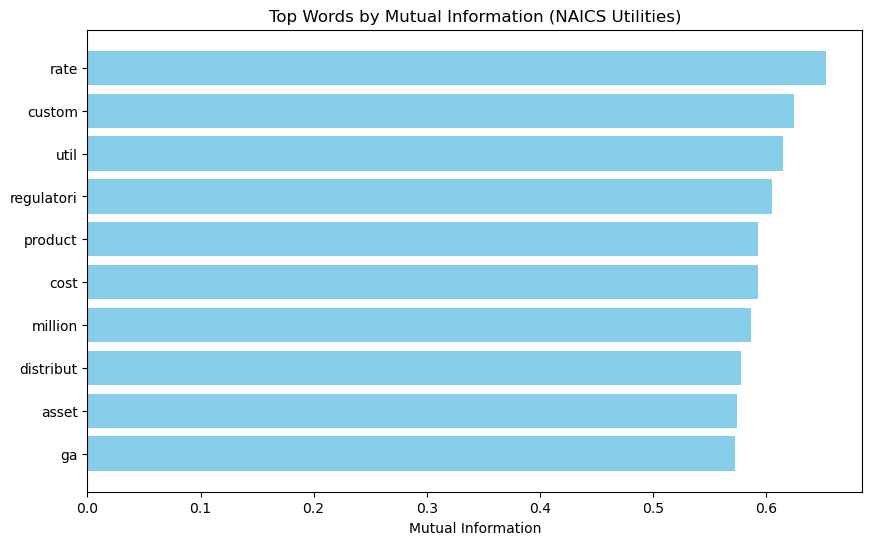

In [61]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the filtered metadata is consistent with your processed corpus
processed_corpus_filtered = [processed_corpus_10k[i] for i in metadata.index]

# Use the 'naics_utilities' column as the labels (1 = utilities, 0 = non-utilities)
labels = np.array(metadata['naics_utilities'])

# Convert the processed corpus back into a format compatible with CountVectorizer
# Each document in processed_corpus_filtered is a list of tokens, so join them into strings
processed_corpus_str = [' '.join(doc) for doc in processed_corpus_filtered]

# Convert the processed text data into a Document-Feature Matrix (DFM) using CountVectorizer
vectorizer = CountVectorizer()
dfm_papers = vectorizer.fit_transform(processed_corpus_str)

# Split DFM into class 0 (non-utilities) and class 1 (utilities)
dfm_0 = dfm_papers[labels == 0]  # Non-utilities documents
dfm_1 = dfm_papers[labels == 1]  # Utilities documents

# Calculate the total number of tokens (word occurrences) in each class
n_0 = dfm_0.sum()  # Total word occurrences in class 0 (non-utilities)
n_1 = dfm_1.sum()  # Total word occurrences in class 1 (utilities)

# Calculate the total number of occurrences of each word in each class
n_j_0 = dfm_0.sum(axis=0).A1  # Total occurrences of each word in class 0 (non-utilities)
n_j_1 = dfm_1.sum(axis=0).A1  # Total occurrences of each word in class 1 (utilities)

# Calculate the ratio difference for each token between the two classes
ratios =  (n_j_1 / n_1) - (n_j_0 / n_0)

# Compute Mutual Information between the DFM and 'naics_utilities'
mi = mutual_info_classif(dfm_papers, labels, discrete_features=True)

# Create a DataFrame to store MI scores and ratios
mi_df = pd.DataFrame({
    'Word': vectorizer.get_feature_names_out(),
    'Mutual Information': mi,
    'Ratio (Utilities - Oil and Gas)': ratios
})

# Sort the DataFrame by mutual information score
mi_df_sorted_by_mi = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the top mutual information scores
print(mi_df_sorted_by_mi.head(10))

# Plot the top 10 words by mutual information score
plt.figure(figsize=(10, 6))
plt.barh(mi_df_sorted_by_mi['Word'][:10], mi_df_sorted_by_mi['Mutual Information'][:10], color='skyblue')
plt.xlabel('Mutual Information')
plt.title('Top Words by Mutual Information (NAICS Utilities)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at the top
plt.show()



For this analysis, I applied mutual information to identify the most distinctive words that differentiate between utility companies (NAICS 22) and companies in the mining, gas, and quarrying sectors (NAICS 21), using Python’s mutual_info_classif function from scikit-learn. This function captures how much information specific words contribute to distinguishing between the two categories, taking into account their frequency in the documents.

To better understand which words are more representative of each category, I also calculated the ratio of word occurrences between utility and non-utility companies. The top 10 most distinctive words for utility companies were rate, custom, util, regulatori, cost, distribut, asset, and charge. For the mining and gas sectors, the tokens product and ga (likely representing "gas") stood out.

These distinctive words offer valuable insights into my research question. For example, the strong presence of the token regulatori in the utility sector highlights the significant focus on regulatory issues in their filings. This aligns with expectations, especially in the energy sector, where companies are heavily regulated by bodies like the Federal Energy Regulatory Commission (FERC). After manually reviewing several 10-Ks, I found that Entergy's 10-K report, for instance, mentioned the word "regulator" 907 times, underscoring how central regulatory discussions are to their business. This suggests that my research idea - measuring climate or energy regulatory risk through earnings calls - could be a useful approach, as utility companies appear to be highly exposed to such risks. I also think that for this exercise and generally for my research question, the way I pre-process my documents could be very important. Looking into bigrams or skipgrams might capture the nuances of climate regulatory risk more effectively. For instance, phrases like "regulatory risk" or "climate regulation" may convey more meaningful insights than individual words alone. This approach could help to better identify the specific regulatory challenges utility companies face and how they might be discussed in the context of climate-related policies.

However, these findings also raise important questions. Could the frequency of certain words be influenced by the length of the documents or the standard structure of 10-K filings? Words like rate and cost, for example, are common financial terms that may not solely reflect regulatory or operational challenges but could be part of broader financial reporting practices across industries. Similarly, the token million might refer to different metrics, such as dollar amounts or quantities like barrels or megawatts (MW), making it difficult to pinpoint its exact meaning in this context. Therefore, while these words provide insight, they may also be influenced by general reporting conventions, rather than being exclusive to sector-specific concerns.



In [64]:
### Mutual Information using Calculation from Class

           Word  Mutual Information  Ratio (Utility - Oil and Gas)
37487   ratemak            0.485392                       0.760561
47965     unbil            0.440900                       0.756720
39902    retail            0.429612                       0.749424
28984        mw            0.386383                       0.685484
40789   royalti            0.363629                      -0.692396
21123   hydraul            0.333131                      -0.663402
30127  nonregul            0.324255                       0.542819
4302     barrel            0.320613                      -0.634601
19157   geophys            0.314745                      -0.595046
19141    geolog            0.313789                      -0.645929


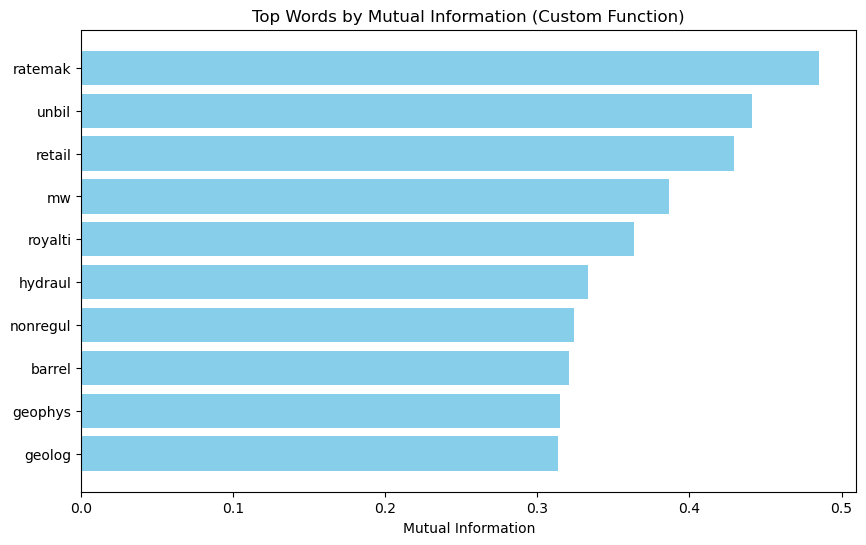

In [62]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt



# Ensure the filtered metadata is consistent with your processed corpus
processed_corpus_filtered = [processed_corpus_10k[i] for i in metadata.index]

# Use the 'naics_utilities' column as the labels (1 = utilities, 0 = non-utilities)
labels = np.array(metadata['naics_utilities'])

# Convert the processed corpus back into a format compatible with CountVectorizer
# Each document in processed_corpus_filtered is a list of tokens, so join them into strings
processed_corpus_str = [' '.join(doc) for doc in processed_corpus_filtered]

# Convert the processed text data into a Document-Feature Matrix (DFM) using CountVectorizer
vectorizer = CountVectorizer()
dfm_papers = vectorizer.fit_transform(processed_corpus_str)

# Custom MI function, similar to your R code, including ratio calculation
def custom_mi_with_ratios(dfm, labels):
    np_class = sum(labels == 1)  # Number of utility documents
    ns_class = sum(labels == 0)  # Number of non-utility documents
    D = np_class + ns_class  # Total number of documents

    # Total number of documents containing each word
    nj = (dfm > 0).sum(axis=0).A1  # Each column sums across documents where the word appears

    # Number of utility and non-utility documents containing each word
    njp = (dfm[labels == 1] > 0).sum(axis=0).A1  # Utility documents containing each word
    njs = (dfm[labels == 0] > 0).sum(axis=0).A1  # Non-utility documents containing each word

    # Number of utility and non-utility documents not containing each word
    nnotjp = (dfm[labels == 1] == 0).sum(axis=0).A1  # Utility docs NOT containing each word
    nnotjs = (dfm[labels == 0] == 0).sum(axis=0).A1  # Non-utility docs NOT containing each word

    # Calculate Mutual Information for each word
    # I added 1e-10 to the denomonator to get rid of the zeros 
    mi = (njp / D * np.log2((njp * D) / (np_class * nj + 1e-10))) + \
         (njs / D * np.log2((njs * D) / (ns_class * nj + 1e-10))) + \
         (nnotjp / D * np.log2((nnotjp * D) / (np_class * (D - nj + 1e-10)))) + \
         (nnotjs / D * np.log2((nnotjs * D) / (ns_class * (D - nj + 1e-10))))

    # Calculate the ratio: (proportion of utility docs) - (proportion of non-utility docs)
    ratio = (njp / np_class) - (njs / ns_class)

    return mi, ratio

# Calculate Mutual Information and ratios for all words
mi_scores, ratios = custom_mi_with_ratios(dfm_papers, labels)

# Create a DataFrame to store the MI scores and ratios
mi_df = pd.DataFrame({
    'Word': vectorizer.get_feature_names_out(),
    'Mutual Information': mi_scores,
    'Ratio (Utility - Oil and Gas)': ratios
})

# Sort the DataFrame by MI score
mi_df_sorted_by_mi = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the top mutual information scores and ratios
print(mi_df_sorted_by_mi.head(10))

# Plot the top 10 words by mutual information score
plt.figure(figsize=(10, 6))
plt.barh(mi_df_sorted_by_mi['Word'][:10], mi_df_sorted_by_mi['Mutual Information'][:10], color='skyblue')
plt.xlabel('Mutual Information')
plt.title('Top Words by Mutual Information (Custom Function)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at the top
plt.show()

For this analysis, I used the mutual information (MI) calculation method provided in class, which treats the presence or absence of words as binary. However, I believe this approach may not be the best fit for my corpus of 149 long documents, as many tokens are likely to appear in most documents simply due to their length. I did not remove infrequent words during pre-processing for this analysis, which could have influenced the results. By filtering out rarer terms, the outcome may have been different.

Even so, the results still provide some interesting insights. The tokens ratemak, unbil, retail, mw, and nonregul are more representative of utility companies, while royalti, hydroaul, barrel, geophys, and geolog are more representative of the mining, quarrying, and oil and gas extraction sectors. These distinctions largely make sense. For example, royalties and barrels are terms strongly associated with the oil and gas industry, while megawatts (mw) and retail are more relevant to utilities.

One token that stood out to me was unbil, which I initially found confusing. After looking through some 10ks, I believe it refers to "unbilled" products or services—goods or services produced but not yet billed—which is likely related to financial practices within utilities. But what particularly caught my attention, in relation to my research question, is the token nonregul being more representative of utility companies. At first, I wasn’t sure what this referred to, but after reviewing a few 10-K filings, I found that it relates to nonregulated energy entities and affiliates or nonregulated energy marketing activities. It’s interesting that this term appears frequently in utility documents, as it may point to a focus on both regulated and nonregulated aspects of their business. This finding provides a new angle for further exploration, particularly in understanding how utilities navigate both regulated and deregulated markets.

Overall, I believe Python's built-in mutual information method is more suited to my corpus and research question, as it focuses on word frequencies, which is the key distinguishing factor I am interested in.

*Task 2 Run a topic model (either LDA or STM) on your corpus.* 

How did you decide on the number of topics for your particular research question? 
Print out the top 5 words in each topic and use these most probable words to assign each of them a label. 
Did you find any topics that surprised you?  Were there any that you thought would be included that are not reflected in the corpus? 
Choose one particular topic that you find interesting.  Read the 5 documents with highest proportion of that topic.  Did how you would label that topic change after reading the most representative five documents?  

In [59]:
import gensim
from gensim import corpora
import pandas as pd

# Assuming 'processed_corpus_10k' is a list of tokenized documents and 'metadata' is your DataFrame with metadata

# Create a dictionary and a document-term matrix (DTM) for gensim
dictionary = corpora.Dictionary(processed_corpus_10k)
corpus = [dictionary.doc2bow(doc) for doc in processed_corpus_10k]  # Convert each document to a bag-of-words

# Run LDA model on the document-term matrix
num_topics = 5  # Set the number of topics as desired
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=135262007)

# Extract the most likely terms for each topic
lda_terms = lda_model.print_topics(num_words=5)

# Extract topic words and their probabilities into a dataframe for better display
topics_data = []

# Loop through each topic and extract the top words
for topic_id, terms in lda_terms:
    topic_words = terms.replace('"', '').split(" + ")  # Clean and split the terms string
    topic_words = [term.split("*")[1] for term in topic_words]  # Extract just the words, not the probabilities
    topics_data.append([f"Topic {topic_id + 1}"] + topic_words)

# Create a DataFrame for better presentation
topics_df = pd.DataFrame(topics_data, columns=["Topic"] + [f"Word {i+1}" for i in range(5)])

# Display the DataFrame in Jupyter or Python environment
topics_df


,Topic,Word 1,Word 2,Word 3,Word 4,Word 5
0,Topic 1,energi,rate,cost,million,includ
1,Topic 2,compani,rate,includ,oper,million
2,Topic 3,compani,ga,oper,oil,natur
3,Topic 4,oper,may,includ,million,servic
4,Topic 5,mine,oper,compani,million,cost


In [60]:
import numpy as np
import pandas as pd

# Create a dictionary to store the top 5 most representative documents for each topic
topic_representative_docs = {}

# Loop through each topic and find the most representative documents for each topic
for topic_index in range(5):  # Loop over the first 5 topics
    most_representative_docs = np.argsort(pi_matrix[:, topic_index])[::-1]  # Sort docs by their probability for the current topic
    
    # Select only the 'time', 'ticker', and 'naics' columns for the top 5 documents for the current topic
    representative_info = metadata.iloc[most_representative_docs[:5]][['time', 'ticker', 'naics']]
    
    # Add to the dictionary
    topic_representative_docs[f"Topic {topic_index + 1}"] = representative_info

# Combine the data for all topics into a single DataFrame for better presentation
combined_representative_docs = pd.concat(topic_representative_docs, names=["Topic", "Index"]).reset_index(level=0)

# Display the combined DataFrame
combined_representative_docs


,Topic,time,ticker,naics
Index,,,,
0,Topic 1,2024-02-29,AEE,2211
54,Topic 1,2024-02-23,ETR,22111
73,Topic 1,2024-02-15,IDA,22111
41,Topic 1,2024-02-23,DUK,2211
55,Topic 1,2024-02-29,EVRG,22111
126,Topic 2,2024-02-23,SJW,221310
37,Topic 2,2024-02-29,CWT,221310
58,Topic 2,2024-02-13,FE,22111
15,Topic 2,2024-02-21,AWR,221310


For this task, I ran a Latent Dirichlet Allocation (LDA) model on my corpus to uncover the underlying topics across the 10-K documents. I chose to use five topics initially because, based on the diversity of industries in my dataset (which covers utilities, mining, and oil/gas sectors), five topics seemed appropriate to capture the main themes without over-segmenting the data. 


Based on the most probable words in each topic, I assigned the following labels:

**Topic 1: Power Generation** – Words like energi, rate, and cost suggest a focus on energy production and pricing.

**Topic 2: Ambiguous** – The words compani, rate, and oper are too general to form a clear theme.

**Topic 3: Oil and Gas** – With terms like ga, oil, and natur, this topic clearly represents the oil and gas industry.

**Topic 4: Ambiguous** – The common words oper, may, and servic make it difficult to discern a specific theme.

**Topic 5: Mining** – Terms like mine, oper, and cost suggest a focus on the mining sector.
Interestingly, the topics seem to divide the companies primarily by their NAICS codes at the 2-digit (sector) and 4-digit (sub-sector) levels, which aligns with my expectations based on the industries these companies represent. However, the presence of general business terms like million dilutes some of the distinctions. Removing such high-frequency but low-relevance words could further refine these topics.
Interestingly, the topics primarily divide the companies according to their NAICS codes, often aligning with both the 2-digit (sector) and 4-digit (sub-sector) levels, which matches expectations based on their industries. However, the inclusion of general business terms like million dilutes the distinctiveness of some topics. Filtering out such high-frequency, low-relevance words could help refine the topic modeling further.

**Key Takeaways:**
The five topics align well with the NAICS industry codes, particularly for the utilities, oil and gas, and mining sectors. The top words for topics that I could clearly define were unsurprising and matched sector expectations.

**Surprising Findings:**
I found it surprising that Topic 2 and Topic 4 remained vague despite having frequent words. I expected clearer distinctions between sectors but found that general business terms like rate, oper, and includ made labeling these topics difficult. This suggests that more aggressive filtering of common business terms might be necessary to improve the topic clarity.

**Detailed Exploration of Topic 1:**
Upon reviewing the five most representative documents for Topic 1 (Power Generation), I found they were primarily from companies in the utility sector (NAICS 2211, electric power generation). This supported my initial labeling of the topic. While my label didn't change after reading the documents, the focus on rate structures and cost analysis became even clearer, emphasizing that these filings heavily address pricing and financial management within the energy sector. Additionally, many documents referenced regulations, including mentions of the Federal Energy Regulatory Commission (FERC) and environmental regulations such as EPA emissions standards.

**New Insight:**
One key takeaway from this exercise is that my research isn't solely about climate regulatory risk; it's more specifically focused on energy regulatory risk. This distinction is significant and hasn’t been fully explored in the literature. For instance, a company facing climate regulatory risk might deal with challenges like a carbon tax or emissions trading schemes, which target carbon emissions directly. In contrast, energy regulatory risk is more about managing regulations around energy rates, grid reliability, or infrastructure mandates. This could involve compliance with the Federal Energy Regulatory Commission (FERC) or state-level public utility commissions, which oversee rate structures and energy distribution. While both are regulatory risks, they impact companies differently and may lead to varying outcomes. For example, companies in Topic 1, such as IDA, Evergy, and Duke, often mention significant coal-fired and gas power generation assets, which reflect their exposure to both regulatory and environmental policies, but this may not be the case for other companies.



